# Branch Prediction: Neural Network  

In [1]:
import numpy as np
from Bio import Phylo
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import io
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn


## Preprocessing

In [2]:
def load_from_txt(data):
    '''Given a .txt file of the data, return an array'''
    loaded_data = []
    
    with open(data) as infile:
        lines = infile.readlines()
        for line in lines:
            line_list = line[2:len(line)-4].split('], ')
            new_line_list = []
            for pair in line_list:#[parent,child,branchlength] objects
                pair = pair[1:].split(', ')
                new_pair = pair
                new_pair[2] = float(pair[2])
                new_line_list.append(new_pair)
            loaded_data.append(new_line_list)
            
    return np.array(loaded_data)

def tree_depth(tree):
    '''given a tree in newick format, return overall depth'''
    
    tree = Phylo.read(io.StringIO(tree), 'newick')
    max_depth = max(tree.depths().values())
    
    return max_depth


def branch_ratio(data, tree_data, index):
    '''given a data_row with form [[parent ,child, branch_length]],
    return data_row with ratios of branch lengths'''
    
    tree = tree_data[tree_data['dreamID'] == index]['ground'].item()
    max_depth = tree_depth(tree)
    
    transformed_data = data #initialize
    for i in range(len(data)):
        transformed_data[i][2] = data[i][2] / max_depth
    return transformed_data

In [4]:
train_path = 'trainingDataFinalOutput.txt'
test_path = 'testingDataFinalOutput.txt'
reference = 'DREAM_data_intMEMOIR.csv'
split = 30
DREAM_data = pd.read_csv(reference, sep = '\t')
DREAM_train = DREAM_data[split:]
DREAM_test = DREAM_data[:split]

train_data = load_from_txt(train_path)


proccessed_data = []

for i in range(1, train_data.shape[0]):
    tree_row = train_data[i]
    proccessed_row = branch_ratio(tree_row, DREAM_train, i)
    proccessed_data.append(proccessed_row)

TRAIN_SET = np.array(proccessed_data)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version


In [5]:
def mutations(pair):
    mutant_row = []
    parent, child, bl = pair[0], pair[1], pair[2]
    mut_count = 0
    prev_muts = 0
    for i in range(10):
        #for every 4 cells
        #[1->0,1->2,already_1->0,already_1->2]
        if parent[i] == '1' and child[i] == '0':
            mutant_row.extend([1,0,0,0])
            mut_count +=1
        elif parent[i] == '1' and child[i] == '2':
            mutant_row.extend([0,1,0,0])
            mut_count +=1
        elif parent[i] == '1' and child[i] == '1':
            mutant_row.extend([0,0,0,0])
        elif parent[i] == '0':
            mutant_row.extend([0,0,1,0])
            prev_muts += 1
        else:
            mutant_row.extend([0,0,0,1])
            prev_muts += 1
    mutant_row.extend([mut_count,prev_muts, bl])
    
    return mutant_row

In [6]:
processed_pairs = []
for tree in TRAIN_SET:
    for pair in tree:
        processed_row = mutations(pair)
        processed_pairs.append(processed_row)
train_validate_numpy = np.array(processed_pairs)
mask1 = np.where(train_validate_numpy[:,42] <= 1)[0]
mask2 = np.where(train_validate_numpy[:,42] != 0)[0]
mask = np.intersect1d(mask1,mask2)
train_validate_numpy = train_validate_numpy[mask, :]
np.random.shuffle(train_validate_numpy)
n_samples = train_validate_numpy.shape[0]
train_data = train_validate_numpy[:(n_samples - 386), :]
validate_data = train_validate_numpy[(n_samples - 386):, :]

In [7]:
print(train_data.shape[0])
print(validate_data.shape[0])

505
386


In [8]:
def loader(data, batch_size = 1):
    '''
    Accepts data array of form Nx2 for the first column of input
    and the 2nd column of ground truth.
    Returns DataLoader object with specific batch_size
    '''
    data_input , data_label = torch.from_numpy(data[:, :42]).type(torch.FloatTensor),\
                              torch.from_numpy(data[:, 42]).type(torch.FloatTensor)
    dataTensorSet = TensorDataset(data_input, data_label)
    dataLoader = DataLoader(dataTensorSet, batch_size = batch_size)
    
    return dataLoader

trainLoader = loader(train_data, batch_size = 16)
validateLoader = loader(validate_data, batch_size = 16 * 2)
training_batch_size = 16
validate_batch_size = 32

## Model Definition

In [10]:
class BranchModel(nn.Module):
    '''
    Multilayer FFN
    6 consequtive FC layers with a final sigmoid activation
    Outputs a value between 0 and 1
    '''
    
    def __init__(self):
        super(BranchModel, self).__init__()
        
        self.fc1 = nn.Linear(42, 42*2)
        self.fc2 = nn.Linear(42*2, 42*4)
        self.fc3 = nn.Linear(42*4, 42*2)
        self.fc4 = nn.Linear(42*2, 42)
        self.final = nn.Linear(42,1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.final(x)
        return torch.sigmoid(x)
    

In [11]:
#hyperparameter/extra function definition
BM = BranchModel()
LR = 1e-4
EPOCHS = 200
optimizer = optim.Adam(BM.parameters(), lr = LR)
criterion = nn.SmoothL1Loss()
score = nn.MSELoss()#want to minimize this
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)
model_save_path = ''
best_model_path = os.path.join(model_save_path, 'Brancher.pth')

## Training

In [12]:
last_score = np.inf

history = {'train_epoch_loss': [], 'validate_epoch_loss': []}

In [13]:
for epoch in range(EPOCHS):

    train_epoch_loss, validate_epoch_loss, epoch_score, batch_n = 0, 0, 0, 0
    ### TRAIN ###
    BM.train()
    for batch_i, (train_input, train_label) in enumerate(trainLoader):
        batch_n += 1
        predicted_label = BM(train_input).view(train_input.shape[0])
        #reset the gradient
        optimizer.zero_grad()

        #compute loss
        loss = criterion(predicted_label, train_label)
        train_epoch_loss += loss

        #backpropagate loss
        loss.backward()
        #update parameters
        optimizer.step()

    train_epoch_loss = train_epoch_loss / (batch_n*training_batch_size) #average Smooth L1

    ### VALIDATE ###
    #NOTE: BATCH_SIZE = SAMPLE SPACE, so 
    batch_n = 0
    BM.eval()
    for batch_i, (validate_input, validate_label) in enumerate(validateLoader):
        batch_n += 1
        predicted_label = BM(validate_input).view(validate_input.shape[0])
        #compute loss
        loss = criterion(predicted_label, validate_label)
        validate_epoch_loss += loss

        #compute score
        batch_score = score(predicted_label, validate_label)
        epoch_score += batch_score

    validate_epoch_loss = validate_epoch_loss/ (batch_n*validate_batch_size)
    epoch_score = epoch_score / (batch_n*validate_batch_size)

    history['train_epoch_loss'].append(train_epoch_loss)
    history['validate_epoch_loss'].append(validate_epoch_loss)        

    #reduce LR On Plateau
    scheduler.step(validate_epoch_loss)
    torch.save(BM.state_dict(), best_model_path)

    #print logs
    print(f'Epoch: {epoch} | ', end = '')
    print(f'Train Loss: {train_epoch_loss:.6f} | ', end = '')
    print(f'Validation Loss: {validate_epoch_loss:.6f} | ', end = '')
    print(f'Validation Score: {epoch_score:.6f} | ', end = '')



Epoch: 0 | Train Loss: 0.001435 | Validation Loss: 0.000458 | Validation Score: 0.000917 | Epoch: 1 | Train Loss: 0.000945 | Validation Loss: 0.000431 | Validation Score: 0.000862 | Epoch: 2 | Train Loss: 0.000900 | Validation Loss: 0.000424 | Validation Score: 0.000848 | Epoch: 3 | Train Loss: 0.000881 | Validation Loss: 0.000420 | Validation Score: 0.000840 | Epoch: 4 | Train Loss: 0.000862 | Validation Loss: 0.000416 | Validation Score: 0.000832 | Epoch: 5 | Train Loss: 0.000845 | Validation Loss: 0.000412 | Validation Score: 0.000824 | Epoch: 6 | Train Loss: 0.000829 | Validation Loss: 0.000408 | Validation Score: 0.000816 | Epoch: 7 | Train Loss: 0.000812 | Validation Loss: 0.000405 | Validation Score: 0.000809 | Epoch: 8 | Train Loss: 0.000797 | Validation Loss: 0.000402 | Validation Score: 0.000804 | Epoch: 9 | Train Loss: 0.000783 | Validation Loss: 0.000401 | Validation Score: 0.000802 | Epoch: 10 | Train Loss: 0.000771 | Validation Loss: 0.000400 | Validation Score: 0.000801 

Epoch: 76 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 77 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 78 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch    80: reducing learning rate of group 0 to 2.3803e-06.
Epoch: 79 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 80 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 81 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch    83: reducing learning rate of group 0 to 2.0233e-06.
Epoch: 82 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 83 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch: 84 | Train Loss: 0.000711 | Validation Loss: 0.000418 | Validation Score: 0.000837 | Epoch    86: reducing learning rate of group 0 t

Epoch: 145 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 146 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 147 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 148 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 149 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 150 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 151 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 152 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 153 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 154 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Validation Score: 0.000837 | Epoch: 155 | Train Loss: 0.000710 | Validation Loss: 0.000419 | Valida

## Evaluation

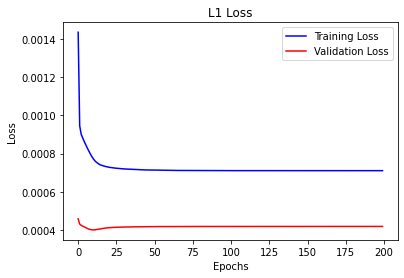

In [14]:
plt.plot(history['train_epoch_loss'], 'b')    
plt.plot(history['validate_epoch_loss'], 'r')
plt.title('L1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [15]:
test_data = load_from_txt(test_path)


proccessed_data = []

for i in range(1, test_data.shape[0]):
    tree_row = test_data[i]
    proccessed_row = branch_ratio(tree_row,DREAM_test,i)
    proccessed_data.append(proccessed_row)
TEST_SET = np.array(proccessed_data)

processed_pairs = []
for tree in TEST_SET:
    for pair in tree:
        processed_row = mutations(pair)
        processed_pairs.append(processed_row)
test_numpy = np.array(processed_pairs)
mask1 = np.where(test_numpy[:,42] <= 1)[0]
mask2 = np.where(test_numpy[:,42] != 0)[0]
mask = np.intersect1d(mask1,mask2)
test_numpy = test_numpy[mask, :]

testLoader = loader(test_numpy, batch_size = 1)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version


In [16]:
#state_dict = torch.load(best_model_path)
#BM.load_state_dict(state_dict)
BM.eval()

test_score = [] 
corr_data = np.zeros((test_numpy.shape[0],test_numpy.shape[1] + 1))
for batch_i, (test_input, test_label) in enumerate(testLoader):
        predicted_label = BM(test_input).view(1)
        #compute score
        batch_score = score(predicted_label, test_label)
        corr_data[batch_i, :42] = test_input.numpy()
        corr_data[batch_i, 42] = test_label
        corr_data[batch_i, 43] = batch_score.item()
        test_score.append(batch_score.item())
        batch_n += 1
print(np.mean(test_score))
print(np.std(test_score))

0.03215381004486872
0.05675527679793238


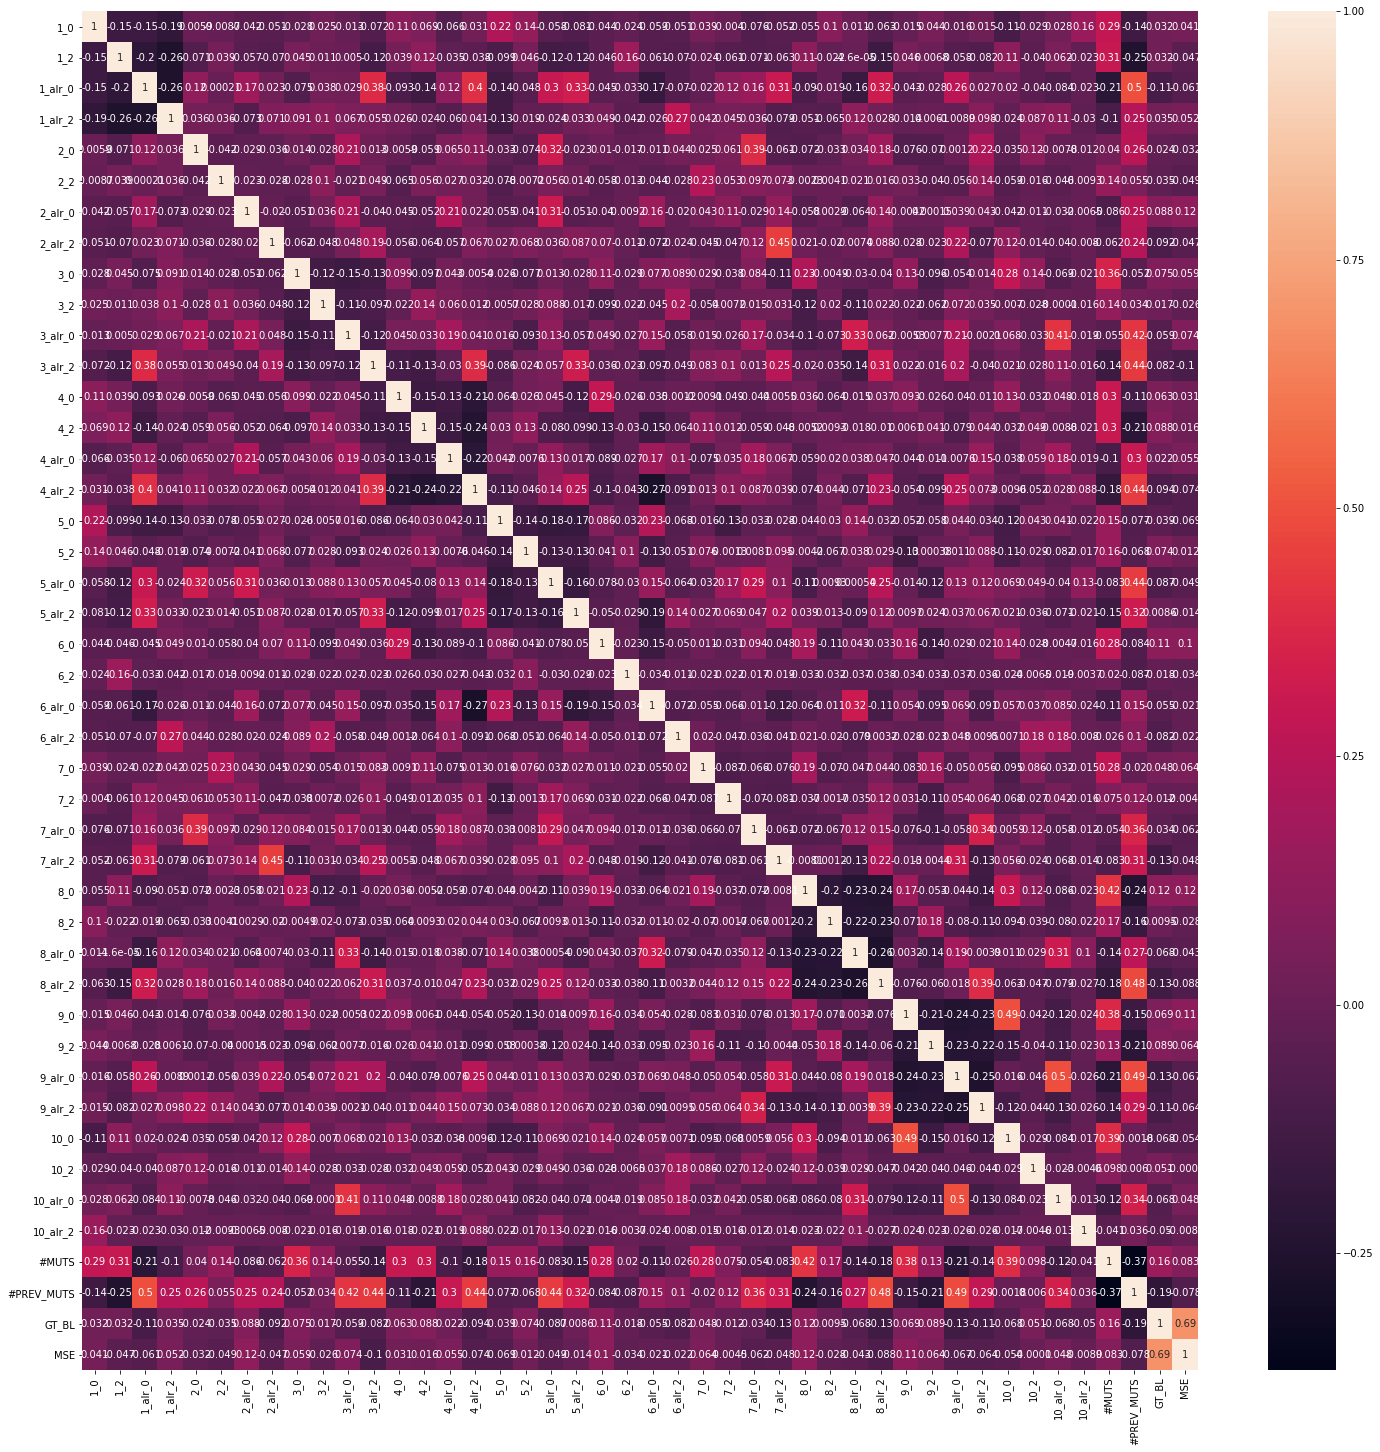

In [17]:
DF = pd.DataFrame(corr_data)
column_names = [str(i) + '_' + j for i in range(1,11) for j in ['0','2','alr_0','alr_2']]
column_names = column_names + ['#MUTS', '#PREV_MUTS', 'GT_BL', 'MSE']
DF.columns = column_names
corr_DF = DF.corr()
plt.rcParams['figure.figsize'] = [25, 25]
sn.heatmap(corr_DF, annot = True)
plt.show()